# <span style="color: Blue; ">Kaggeleのtitanicの生存者予測</span>
## 使用するData:https://www.kaggle.com/c/titanic
- trainデータ（891行、12列）、tesｔデータ（418行、11列）
- 生存1、生存ではない0のどちらかを機械学習で予測
- 説明変数は生存率とクロス集計をして生存、生存ではないの幅が最大30%以上あれば採用
- 度数が50以下は過学習になる可能性があるので、他の特徴と統一することにする
- メインは特徴がない説明変数に強い決定木系を使うが、決定木以外のモデルも使用するため、予測にあまり影響がない説明変数は削除する

## 使用外部ライブラリ

- numpy==1.18.1
- matplotlib==3.1.3
- pandas==1.0.1
- seaborn==0.10.0
- scikit-learn==0.22.1

## ■dataの読み込み
- ファイル読み込みを行い、train データとtestデータを合わせる
- 前処理のmoduleをimport
- 提出データのために、testデータのpassengerIDを変数とする
- 説明変数のクロス集計のためにtrainデータのSurvivedを用意する
- trainデータとtestデータを再び分けれるように、train_or_test列を作成する

In [817]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
passengerID = test['PassengerId']
Survived = train['Survived']
train['train_or_test']='train'
test['train_or_test']='test'
alldata = pd.concat([train,test], axis=0, sort=False)

## ■Dataの全体確認
- headで頭５件のデータを確認
- infoでデータ数、データの種類を確認
- describeで統計データを確認する

In [818]:
alldata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_or_test
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [819]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1046 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  train_or_test  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [820]:
alldata.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


## ■Pclassの生存割合を確認
- Pclassは、１、２、３と３つに分かれている
- 【仮説】チケットの等級が高い人は生存率が高い

- 3は死亡者が70%付近、1は死亡者35%付近と35%以上の幅はある

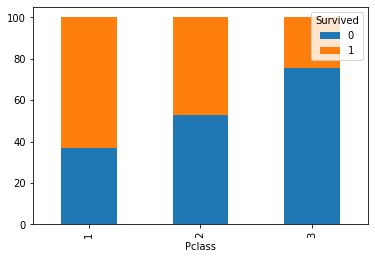

In [821]:
pclassdate = pd.crosstab(train['Pclass'],train['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
pclassdate.plot.bar(stacked=True)

- 度数も50以上あるので、説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|

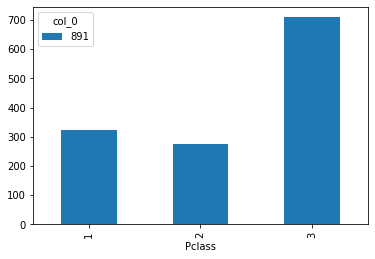

In [822]:
pclassdate = pd.crosstab(alldata['Pclass'],alldata.Survived.count())
pclassdate.plot.bar(stacked=True)

## ■Nameの長さで生存率を確認

- 【仮説】名前の長さによって、その人の特徴が変わるかもしれないので、名前の長さを説明変数を確認してみる
- "Name_length"列を作成して、Name列の名前の長さを挿入する
- 名前の長さをヒストグラムで確認

(array([676., 479., 133.,  20.,   1.]),
 array([12., 26., 40., 54., 68., 82.]),
 <a list of 5 Patch objects>)

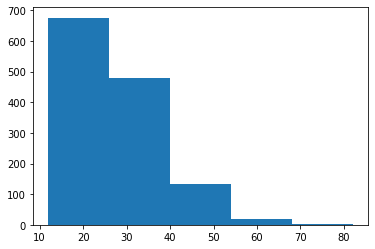

In [823]:
alldata["Name_length"] = alldata['Name'].map(lambda x: len(x))
plt.hist(alldata['Name_length'],bins=5)

- 名前の長さ25以下を1に、25〜39まで2に、39以上を3に、主に1つの段差ごとにユニークを作成、39以上は度数が少ないため1つにまとめる
- 1が死亡者70%、3が20%以下なので特徴があることを確認

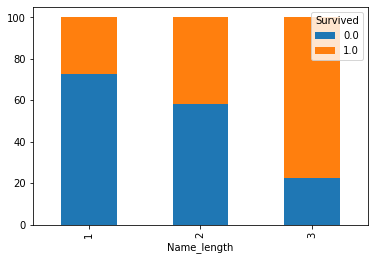

In [824]:
alldata.loc[(alldata['Name_length'] >10 ) & (alldata['Name_length'] <= 25 ),['Name_length']]= 1
alldata.loc[(alldata['Name_length'] > 25) & (alldata['Name_length'] <= 39) ,['Name_length']]= 2
alldata.loc[(alldata['Name_length'] > 39) ,['Name_length']]= 3
name_lengthdate = pd.crosstab(alldata['Name_length'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
name_lengthdate.plot.bar(stacked=True)

- 度数が50以上なので説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3|

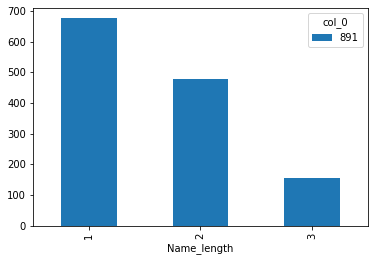

In [825]:
name_lengthdate = pd.crosstab(alldata['Name_length'],alldata.Survived.count())
name_lengthdate.plot.bar(stacked=True)

## ■Nameの敬称から生存率を確認
- 【仮説】名前の敬称によって、その人の特徴があるかもしれないので確認してみる
- honorific列を作成して、splitでNameのそれぞれの敬称を挿入
- 死亡率が80%以上のMrとその他の100%の敬称を1に
- MissとMrsを2に、その他の生存者しかいない敬称も2とする
- その他を全て3にする

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3|
|honorific|1,2,3|

In [826]:
alldata['honorific'] = alldata['Name'].map(lambda x: x.split(', ')[1])
alldata['honorific'] = alldata['honorific'].map(lambda x: x.split('. ')[0])

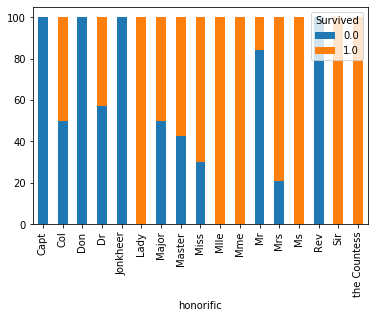

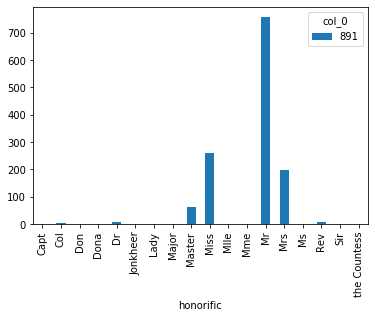

In [827]:
honorificdate = pd.crosstab(alldata['honorific'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
honorificdate.plot.bar(stacked=True)
honorificdate = pd.crosstab(alldata['honorific'],alldata.Survived.count())
honorificdate.plot.bar(stacked=True)

In [828]:
alldata['honorific'] = alldata['honorific'].replace({'Mr': 1, 'DonI': 1,'Capt':1,'Rev':1,'Jonkheer':1,'Don':1})
alldata['honorific'] = alldata['honorific'].replace({'Miss': 2, 'Mrs': 2,'Mlle':2,'Mme':2, 'Ms': 2,'Sir':2,'he Countess':2,'Lady':2})
alldata['honorific'] = alldata['honorific'].replace({'Col': 3,'Dr': 3,'Major':3,'Master':3,'Dona':3,'the Countess':3})

- 1の死亡者が85%、2が30%なのど、敬称ごとに特徴があるのを確認

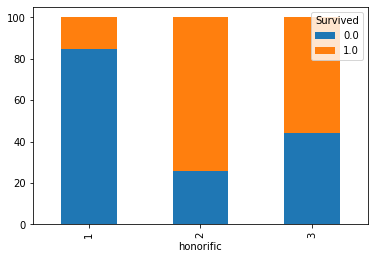

In [829]:
honorificdate = pd.crosstab(alldata['honorific'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
honorificdate.plot.bar(stacked=True)

In [830]:
alldata['honorific'].value_counts()

1    768
2    464
3     77
Name: honorific, dtype: int64

- 3の度数は怪しいが、50はありそうなので　説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3|
|honorific|1,2,3|

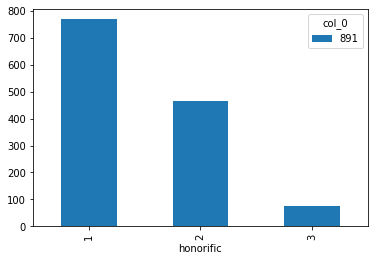

In [831]:
honorificdate = pd.crosstab(alldata['honorific'],alldata.Survived.count())
honorificdate.plot.bar(stacked=True)

## ■Sexと生存率を確認

- 性別で生存率の確認をする
- 【仮説】女性の生存率は高いかもしれない

- 男性を1、女性を2にする
- 男性と女性で50%以上の幅を確認

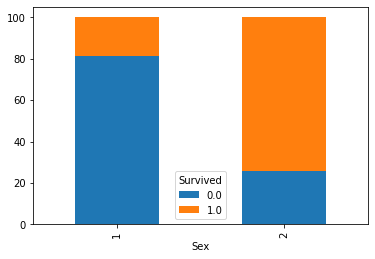

In [832]:
alldata.loc[(alldata["Sex"] == "male"), ["Sex"]]=1
alldata.loc[(alldata["Sex"] == "female"),["Sex"]]=2

sexdata = pd.crosstab(alldata['Sex'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
sexdata.plot.bar(stacked=True)

-　度数も問題なしなので、説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3|
|honorific|1,2,3|
|Sex|1,2|

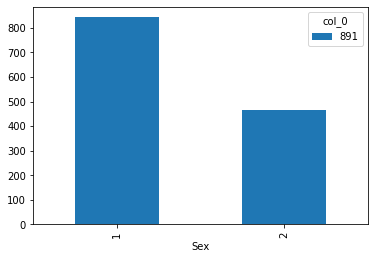

In [833]:
sexdata = pd.crosstab(alldata['Sex'],alldata.Survived.count())
sexdata.plot.bar(stacked=True)


## ■年齢の記載有り無しで生存率の確認

- 年齢情報の有無により、何か特徴があるかもしれないので確認をする
- 【仮説】年齢の記載は必須項目ではない、たまたま情報がなかっただけかもしれないが、念のため確認してみる

- Age_check列を作成して、年齢の記載がある人を1、年齢の記載がない人を2とする
- 年齢の有無による生存率の幅は少ないため、説明変数としては不採用


|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|

|不採用項目|
|-|
|Age_check|

In [834]:
alldata["Age_check"] = alldata['Age'] 
alldata["Age_check"] = alldata["Age_check"].fillna(2)
alldata.loc[(alldata["Age_check"] != 2),["Age_check"]]=1

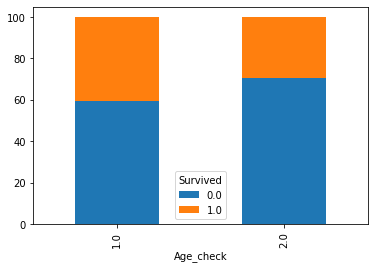

In [835]:
age_checkdate = pd.crosstab(alldata['Age_check'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
age_checkdate.plot.bar(stacked=True)


## ■年齢での生存率の確認

- 年齢によって生存率が違うかもしれないので確認をする
- 【仮説】子供の生存値が高そうだから確認をしてみる

- 年齢の度数をヒストグラムで確認
- 17歳以下を1に、15歳以上32歳以下を2に、33歳以上47歳以下を3と段差ごとに分ける、47歳以上を4とする
- 幅が30%より少ないので説明変数としては不採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|

|不採用項目|
|-|
|Age_check|
|Age|

/Users/tatsuhiro/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tatsuhiro/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([134., 524., 269., 106.,  13.]),
 array([ 0.17 , 16.136, 32.102, 48.068, 64.034, 80.   ]),
 <a list of 5 Patch objects>)

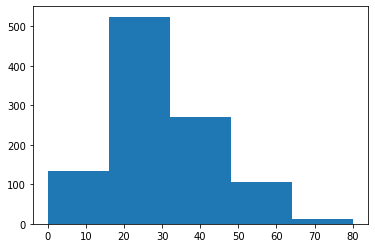

In [836]:
plt.hist(alldata['Age'],bins=5)

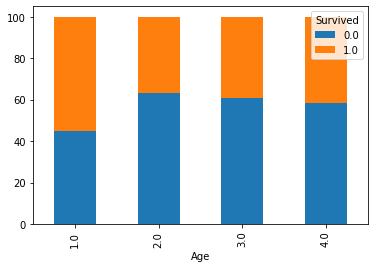

In [837]:
alldata.loc[(alldata["Age"] < 17), ["Age"]]=1
alldata.loc[(alldata["Age"] >= 15) & (alldata["Age"] <= 32), ["Age"]]=2
alldata.loc[(alldata["Age"] > 32) & (alldata["Age"] <=47), ["Age"]]=3
alldata.loc[(alldata["Age"] > 47), ["Age"]]=4
agedata = pd.crosstab(alldata['Age'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
agedata.plot.bar(stacked=True)

## ■SibSpで生存率の確認
- sibSp（配偶者、兄弟の有無）によって生存率があるか確認をする
- 【仮説】配偶者がいると、生存率は少し高いかもしれない

- SibSp1とSibSp5は50%の幅はある

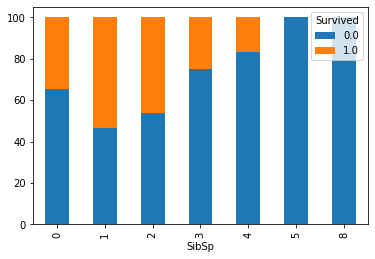

In [838]:
sibspdata = pd.crosstab(alldata['SibSp'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
sibspdata.plot.bar(stacked=True)

-5の度数が少ない、度数が多い0と1は幅が少ないため説明変数としては不採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|


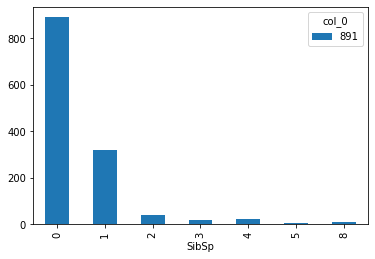

In [839]:
sibspdata = pd.crosstab(alldata['SibSp'],alldata.Survived.count())
sibspdata.plot.bar(stacked=True)

## ■Parchで生存率の確認

- Parch（親、子供）の違いによって、特徴があるかもしれないので確認をする
- 【仮説】Parchが高ければ、生存率は高そう

- 30%以上の幅の項目はある

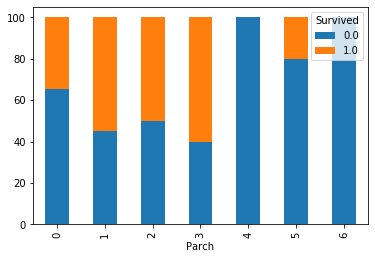

In [840]:
parchdata = pd.crosstab(alldata['Parch'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
parchdata.plot.bar(stacked=True)

- 0、1、２は幅が狭く、それ以外は度数が少ないので説明変数としては不採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|

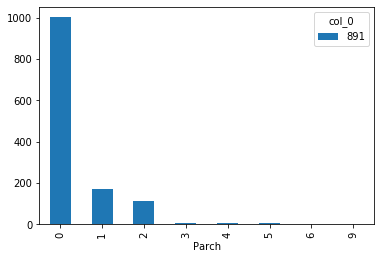

In [841]:
parchdata = pd.crosstab(alldata['Parch'],alldata.Survived.count())
parchdata.plot.bar(stacked=True)

## ■Familyで生存率を確認する

- 家族の人数によって、特徴が現れるかもしれないので確認をしてみる
- 【仮説】SibSpとParchは特徴としてはいまいちだったかもしれないが、2つの特徴あわすことによって、大きな特徴になるかもしれない

- SibspとParchの数字を足してFamily sizeで列を作成する
- 3と10で十分な幅はある

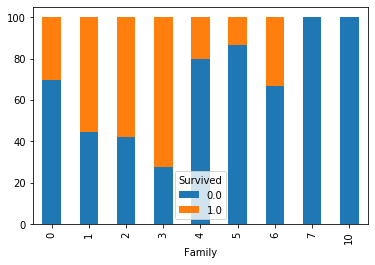

In [842]:
alldata["Family"]= alldata['SibSp']  + alldata['Parch']
familydata = pd.crosstab(alldata['Family'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
familydata.plot.bar(stacked=True)

- 2と1が近いので統一する
- 3も度数が少ないため、1に統一する
- 4以降は度数が少ないため全て0にする



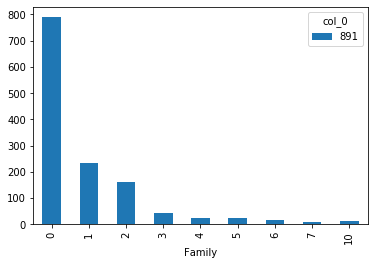

In [843]:
familydata = pd.crosstab(alldata['Family'],alldata.Survived.count())
familydata.plot.bar(stacked=True)

In [844]:
alldata.loc[(alldata['Family']==2),['Family']]=1
alldata.loc[(alldata['Family']==3),['Family']]=1
alldata.loc[(alldata['Family'] != 1),['Family']]=0

- 0と1で再度確認をする、説明変30% 以上

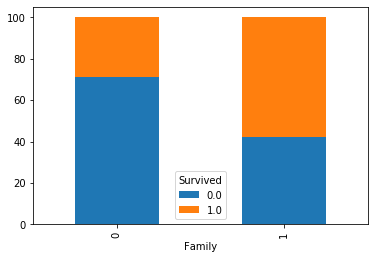

In [845]:
pclassdate = pd.crosstab(alldata['Family'],alldata['Survived']).apply(lambda x:x/x.sum()*100,axis=1)
pclassdate.plot.bar(stacked=True)

- 度数も問題ないので、説明変数として採用

|採用項目|
|-|
|Pclass1,2,3|
|Name_length1,2,3,4|
|honorific1,2,3|
|Sex1,2|
|Family1,2|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|

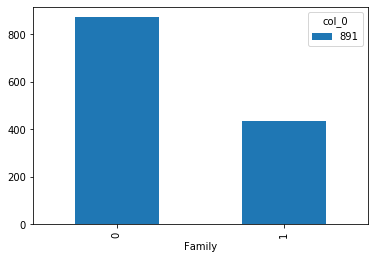

In [846]:
pclassdate = pd.crosstab(alldata['Family'],alldata.Survived.count())
pclassdate.plot.bar(stacked=True)

## チケットの種類で生存率を確認する

- チケットの種類によって、特徴があるかもしれないので確認をしてみる
- 【仮説】Pclassで特徴があるために、チケットの種類でも特徴は期待できる

- Ticket列の説明変数を頭文字１文字にする

In [847]:
alldata["Ticket"] = alldata["Ticket"].map(lambda x:str(x)[0])

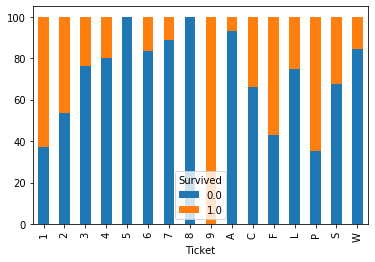

In [848]:
ticketdata = pd.crosstab(alldata['Ticket'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
ticketdata.plot.bar(stacked=True)

- ユニークが多く、度数が少ない説明変数が多いので近い値を統一していく
- 40%付近のFとPを1に統一する
- 60%付近のCとLとSを2で統一する
- その他70%以上を3に統一する


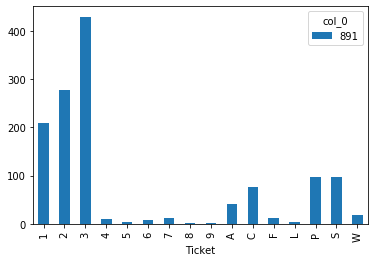

In [849]:
ticketdata = pd.crosstab(alldata['Ticket'],alldata.Survived.count())
ticketdata.plot.bar(stacked=True)
alldata['Ticket'].replace({'F': 1, 'P': 1})
alldata['Ticket'].replace({'C': 2, 'L':2,'S': 2})
alldata.loc[(alldata['Ticket'] != "1") & (alldata['Ticket'] != "2"),['Ticket']]= "3"

- クロス集計で再度確認をする
- 1と3の幅を確認30%はある

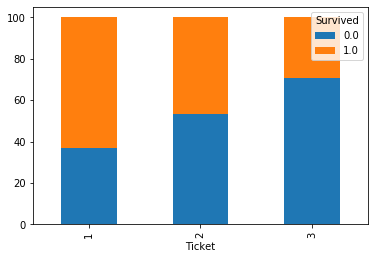

In [850]:
ticketdata = pd.crosstab(alldata['Ticket'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
ticketdata.plot.bar(stacked=True)

- 統一した後は度数が50以上どれもあるので説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|
|honorific|1,2,3|
|Family|1,2|
|Ticket|1,2,3|


|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|


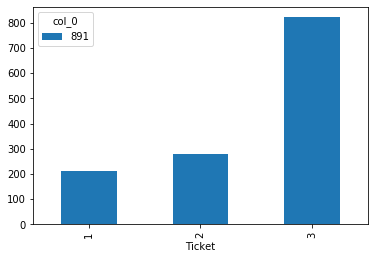

In [851]:
ticketdata = pd.crosstab(alldata['Ticket'],alldata.Survived.count())
ticketdata.plot.bar(stacked=True)

## ■Fareで生存率確認

- Fareによる特徴を確認
- 【仮説】チケットやPclassが特徴あったので、Fareも特徴がありそう

- ヒストグラムで度数分布を確認する
- 10以下を1、10より高い20以下を2
- 20より高い30以下を3、30より高い40以下を4、40より高いを5とする
- 空白があるので、最頻値を埋める

(array([491., 261., 206.,  86.,  22.,  56.,  30.,  39.,  22.,  11.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

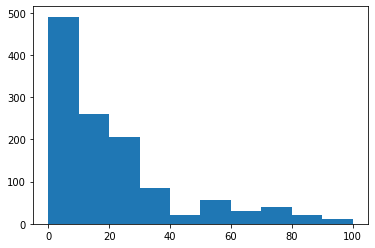

In [852]:
plt.hist(alldata['Fare'],bins=10, range=(0, 100))

In [853]:
alldata.Fare.fillna(alldata.Fare.mode()[0], inplace=True)
alldata.loc[(alldata['Fare'] <=10) ,['Fare']]= 1
alldata.loc[(alldata['Fare'] > 10) & (alldata['Fare'] <= 20),['Fare']]= 2
alldata.loc[(alldata['Fare'] > 20) & (alldata['Fare'] <= 30),['Fare']]= 3
alldata.loc[(alldata['Fare'] > 30) &(alldata['Fare'] <= 40),['Fare']]= 4
alldata.loc[(alldata['Fare'] > 40),['Fare']]= 5

- クロス集計で確認をする
- ２と3が近いので統一する
- 4と2も近いので統一する

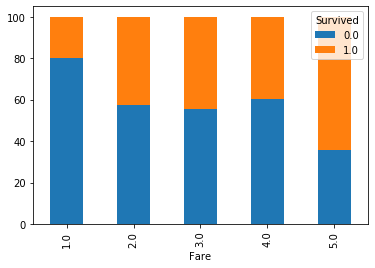

In [854]:
faredata = pd.crosstab(alldata['Fare'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
faredata.plot.bar(stacked=True)
alldata.loc[(alldata['Fare'] == 3) ,['Fare']]= 2
alldata.loc[(alldata['Fare'] == 4) ,['Fare']]= 2

- 1と5で30%以上の幅を確認

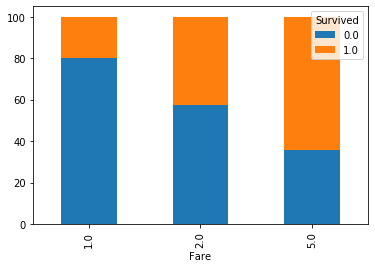

In [855]:
faredata = pd.crosstab(alldata['Fare'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
faredata.plot.bar(stacked=True)

- 度数は問題ないので、説明変数として採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|
|honorific|1,2,3|
|Family|1,2|
|Ticket|1,2,3|
|Fare|1,2,5|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|

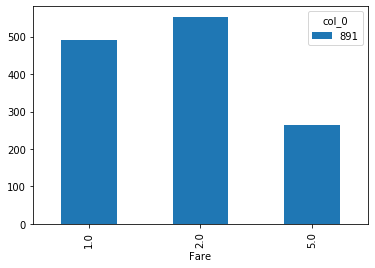

In [856]:
faredata = pd.crosstab(alldata['Fare'],alldata.Survived.count())
faredata.plot.bar(stacked=True)

## ■Cabinでの生存率を確認

- Cabin（客室番号）による特徴を確認する
- 【仮説】Cabinによって、移動などに影響があるため、特徴はありそうだが、欠損値が多いため、説明数として使うのは難しいかも

- 空白があるのでNoneで埋める
- cabinの１文字目を取得する

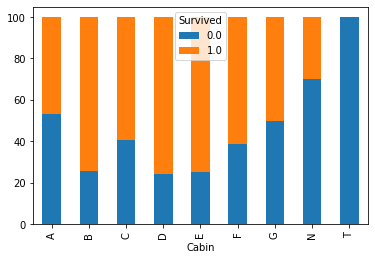

In [857]:
alldata['Cabin'] = alldata['Cabin'].fillna("None")
alldata['Cabin'] = alldata['Cabin'].map(lambda x:str(x)[0])
cabindata = pd.crosstab(alldata['Cabin'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
cabindata.plot.bar(stacked=True)

- Tは度数が少ないので、Nに合わして、１とする、BDEは統一して2、その他は3とする

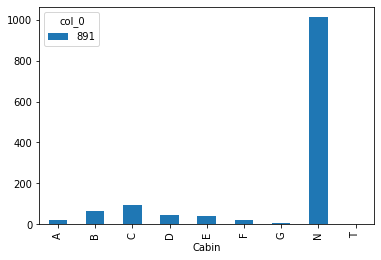

In [858]:
cabindata = pd.crosstab(alldata['Cabin'],alldata.Survived.count())
cabindata.plot.bar(stacked=True)

In [859]:
alldata['Cabin'] = alldata['Cabin'].replace({'T': 1, 'N': 1})
alldata['Cabin'] =alldata['Cabin'].replace({'B': 2, 'D': 2,'E': 2})
alldata['Cabin'] = alldata['Cabin'].replace({'A': 3, 'C': 3,'F': 3,'G': 3})

-　再度クロス集計で確認をする
- 1と2で30%以上の幅を確認

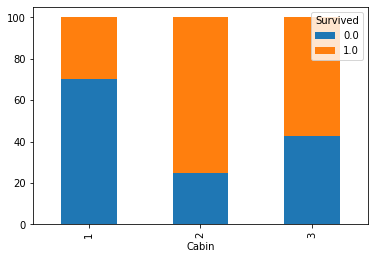

In [860]:
cabindata = pd.crosstab(alldata['Cabin'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
cabindata.plot.bar(stacked=True)

- 度数に問題がないので説明変数として採用


|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|
|honorific|1,2,3|
|Family|1,2|
|Ticket|1,2,3|
|Fare|1,2,5|
|Cabin|1,2,3|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|

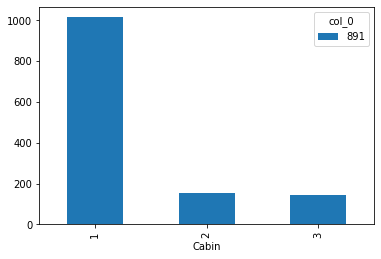

In [861]:
cabindata = pd.crosstab(alldata['Cabin'],alldata.Survived.count())
cabindata.plot.bar(stacked=True)

## Embarkedで生存率の確認
- Embarked(出港地)による特徴を確認する
- 【仮説】
出港地による、特徴はあまりなさそうだが、確認はしてみる

- 欠損値を最頻値Noneで埋める
- それぞれのembarkedの生存率を確認
- Noneは度数が２しかなく、他は幅が30%以下なので、説明変数としては不採用

|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|
|honorific|1,2,3|
|Family|1,2|
|Ticket|1,2,3|
|Fare|1,2,5|
|Cabin|1,2,3|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|
|Embarked|

In [862]:
alldata["Embarked"] = alldata["Embarked"].fillna("None")

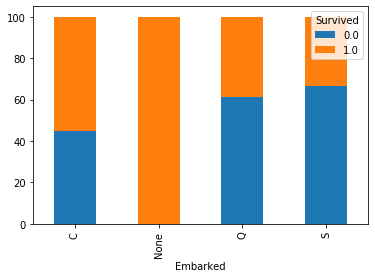

In [863]:
embarkeddata = pd.crosstab(alldata['Embarked'],alldata['Survived']).apply(lambda x: x/x.sum() * 100, axis=1)
embarkeddata.plot.bar(stacked=True)

## ■データの整理

- 不採用変数列を削除
- Name列もユニークが多すぎるので削除
- Survived列は目的変数のため削除する、PassengerIdも特徴と関係がないので削除する


|採用項目|値|
|-|-|
|Pclass|1,2,3|
|Name_length|1,2,3,4|
|honorific|1,2,3|
|Sex|1,2|
|honorific|1,2,3|
|Family|1,2|
|Ticket|1,2,3|
|Fare|1,2,4|
|Cabin|1,2,3|

|不採用項目|
|-|
|Age_check|
|Age|
|SibSp|
|Parch|
|Embarked|

|削除列|
|-|
|Name|
|Survived|

In [864]:
delcols =["Age_check","Age","SibSp","Parch","Embarked","Name","Survived","PassengerId"]
alldata = alldata.drop(delcols, axis=1)

- 改めて、データをinfoで確認をする
- 欠損が全て埋まっているのを確認
- 数値の大きさに影響されずにカテゴリーとして学習をしたいため、objectデータに変換する
- 学習がしやすくなるようにget_dummiesで１つの特徴ごとに列を作成する

In [865]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         1309 non-null   int64  
 1   Sex            1309 non-null   object 
 2   Ticket         1309 non-null   object 
 3   Fare           1309 non-null   float64
 4   Cabin          1309 non-null   int64  
 5   train_or_test  1309 non-null   object 
 6   Name_length    1309 non-null   int64  
 7   honorific      1309 non-null   int64  
 8   Family         1309 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 102.3+ KB


In [866]:
alldata = alldata.astype('object')
alldata = pd.get_dummies(alldata)


## ■学習用データの作成

- test データとtrainデータに戻す（train_or_test_train列が1の列はtrain、train_or_test_test列が1の列は1の列はtestにする）
- train_or_testを削除
- 最初に作ったSurvivedを目的ラベルのy_trainにする
- trainデータを学習用のx_trainにする
- testデータをx_testにする

In [867]:
train = alldata.query('train_or_test_train == 1')
test =  alldata.query('train_or_test_test == 1')

delcols =["train_or_test_test","train_or_test_train"]

# train = alldata.query('train_or_test == "train"')
# test =  alldata.query('train_or_test == "test"')
# delcols =["train_or_test"]
train = train.drop(delcols ,axis=1)
test = test.drop(delcols ,axis=1)
y_train = Survived
x_train = train
x_test = test

- 提出するまでに、各モデルの精度を確認するため、学習用データから、検証用データを作成する

In [868]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train, test_size=0.3)

## ■decisiontreeで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train dataで学習を行う、パラメータも最適化する
- 検証用dataでscoreの精度を確認

In [869]:
param_grid= {"max_depth": [3, 4,None],
             "splitter": ["best", "random"],
              "min_samples_split": [2, 3, 5],
              "min_samples_leaf": [2, 3, 5],
              "criterion": ["gini", "entropy"]}

In [870]:
score = 'f1'
decisiontree = GridSearchCV(
DecisionTreeClassifier(),
param_grid = param_grid,
cv=10,
)
decisiontree.fit(x_train,y_train)
y_pred1 = decisiontree.predict(x_test)
acc_decisiontree =round(decisiontree.score(x_valid,y_valid)*100,2)
acc_decisiontree

84.33

## ■random_forestで機械学習で計算を行う
- グリッドサーチで学習に使うパラメータをセットする
- train dataで学習を行う、パラメータも最適化する
- 検証用dataでscoreの精度を確認

In [879]:
param_grid = {"max_depth": [3, 4,None],
              "n_estimators":[500,600,700],
              "min_samples_split": [2,3, 5],
              "min_samples_leaf": [2, 3, 5],
              "criterion": ["gini", "entropy"]}

In [880]:
score = 'f1'
random_forest = GridSearchCV(
RandomForestClassifier(),
param_grid = param_grid,
cv=5,
)

random_forest.fit(x_train, y_train)
y_pred2 = random_forest.predict(x_test)
random_forest.score(x_valid, y_valid)

acc_random_forest = round(random_forest.score(x_valid, y_valid) * 100, 2)
acc_random_forest

85.07

## ■support vector machineで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train dataで学習を行う、パラメータも最適化する
- 検証用dataでscoreの精度を確認

In [873]:
param_grid_linearscv = {'C':[1,10,20,100],
                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                      }

In [874]:
score ='f1'
linearscv =GridSearchCV(
SVC(),
param_grid = param_grid_linearscv,
cv=5,
)
linearscv.fit(x_train,y_train)
y_pred3 = linearscv.predict(x_test)
aa_linearscv = round(linearscv.score(x_valid,y_valid)*100,2)
aa_linearscv

85.45

## ■LogisticRegressionで機械学習を行う
- グリッドサーチで学習に使うパラメータをセットする
- train dataで学習を行う、パラメータも最適化する
- 検証用dataでscoreの精度を確認

In [875]:
param_grid_logisticregression = {'C': [1, 0.1, 0.01],
                        'penalty':["l1","l2"]}

In [876]:
score ='f1'
ｌogisticregression =GridSearchCV(
LogisticRegression(),
param_grid = param_grid_logisticregression,
cv=5,
)
ｌogisticregression.fit(x_train,y_train)
y_pred4 = linearscv.predict(x_test)
aa_ｌogisticregression = round(ｌogisticregression.score(x_valid,y_valid)*100,2)
aa_ｌogisticregression

/Users/tatsuhiro/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/tatsuhiro/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/tatsuhiro/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarn

80.97

- 検証用スコアをそれぞれ比較

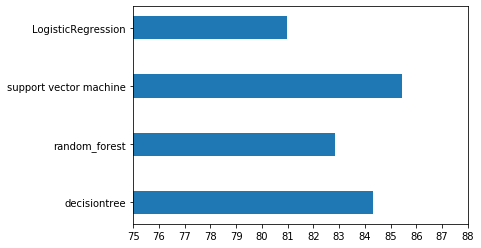

In [877]:
plt.barh([0,1,2,3], [acc_decisiontree,acc_random_forest,aa_linearscv,aa_ｌogisticregression], height=0.4, align="center")
plt.yticks([0,1,2,3],['decisiontree', 'random_forest', 'support vector machine', 'LogisticRegression'])
plt.xlim([75,88])
plt.xticks([75,76,77,78,79,80,81,82,83,84,85,86,87,88])
plt.show()

## ■提出用のfile作成

- 一番精度が良かったy_predを入力
- 提出用のcsv fileを作成する

In [881]:
submission = pd.DataFrame({
        "PassengerId": passengerID,
        "Survived": y_pred2
    })
submission.to_csv('submission.csv', index=False)

## ■提出結果

- 最高で上位４％に ![スコア](data/score.jpg "スコア")